In [2]:
!pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/376.9 MB ? eta -:--:--
   ---------------------------------------- 0.2/376.9 MB 4.9 MB/s eta 0:01:17
   ---------------------------------------- 0.5/376.9 MB 6.6 MB/s eta 0:00:58
   ---------------------------------------- 1.3/376.9 MB 10.2 MB/s eta 0:00:37
   ---------------------------------------- 2.9/376.9 MB 16.9 MB/s eta 0:00:23
    --------------------------------------- 5.1/376.9 MB 23.3 MB/s eta 0:00:16
    --------------------------------------- 6.1/376.9 MB 23.1 MB/s eta 0:00:17
    --------------------------------------- 8.5/376.9 MB 27.2 MB/s eta 0:00:14
   - -------------------------------------- 11.1/376.9 MB 40.9 MB/s eta 0:00:09
   - -------------------------------------- 11.5/376.9 MB 43.5 MB/s eta 0:00:09
  

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import pathlib
import scipy
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
image_dir = "Dataset1/images/images"

In [18]:
image_paths = []
breed_names = []
breed_ids = []
initial_breed_id = -1
initial_breed_name = ""

for path in pathlib.Path(image_dir).iterdir():
    image_paths.append(path.name.split("/")[-1])
    breed_name = path.name.rsplit("_", 1)[0]
    if breed_name != initial_breed_name:
        initial_breed_id += 1
        initial_breed_name = breed_name
    breed_names.append(breed_name)
    breed_ids.append(initial_breed_id)

In [19]:
# create a dataframe
df = pd.DataFrame({
    "image_path": image_paths,
    "breed_name": breed_names,
    "breed_id": breed_ids
})

# save csv

df.to_csv("breed_images.csv", index=False)

In [20]:
images_df = pd.read_csv("breed_images.csv")

In [27]:
img_height = 64
img_width = 64
batch_size = 32

images = []
labels = []

for index, row in images_df.iterrows():
    image_path = os.path.join(image_dir, row['image_path']) 
    label = row['breed_id'] 
    image = PIL.Image.open(image_path).convert('RGB') 
    image = image.resize((img_height, img_width)) 
    image = np.array(image) 
    images.append(image) 
    labels.append(label)

In [28]:
images = np.array(images)
labels = np.array(labels)

train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.15, random_state=42)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1765, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 5172
Validation set size: 1109
Test set size: 1109


In [29]:
class_names = np.unique(train_labels)
print(class_names)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


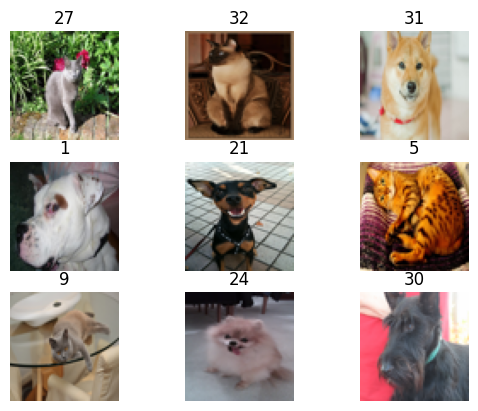

In [30]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
normalization_layer = layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9843138


In [38]:
from keras.callbacks import ModelCheckpoint
callback_val = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.5),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(1024, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.8),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 52,390,053 (199.85 MB)

 Trainable params: 52,378,277 (199.81 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [41]:
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback_val, tf.keras.callbacks.LearningRateScheduler(scheduler)]
)

Epoch 1/100


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


162/162 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.0589 - loss: 4.2334 - val_accuracy: 0.0216 - val_loss: 4.8402 - learning_rate: 1.0000e-04
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.1154 - loss: 3.7236 - val_accuracy: 0.0225 - val_loss: 5.7083 - learning_rate: 1.0000e-04
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.1538 - loss: 3.4793 - val_accuracy: 0.0523 - val_loss: 4.5546 - learning_rate: 1.0000e-04
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.1929 - loss: 3.1694 - val_accuracy: 0.1226 - val_loss: 4.1167 - learning_rate: 1.0000e-04
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.2241 - loss: 2.8778 - val_accuracy: 0.1623 - val_loss: 3.5823 - learning_rate: 1.0000e-04
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.2780 - loss: 2.6542 - val_accuracy: 0.1713 - val_loss: 3.6103 - learning_rate: 1.0000e-04
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy

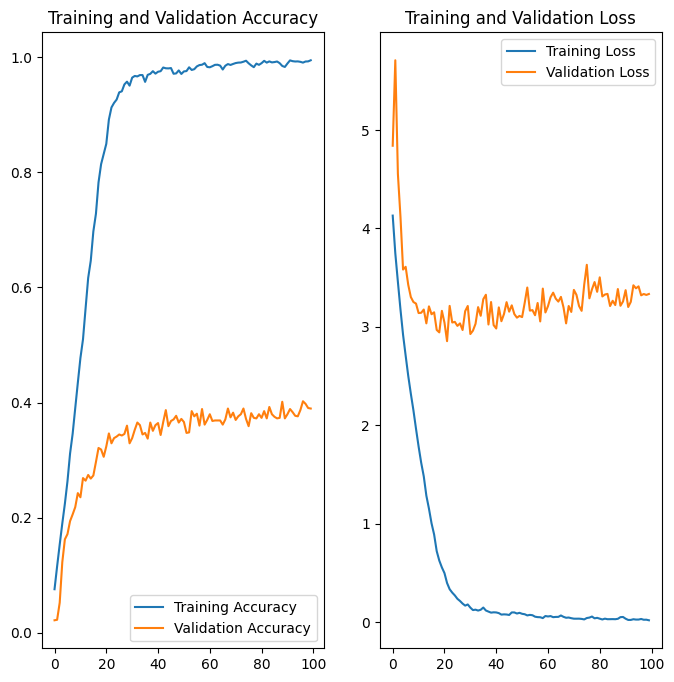

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    validation_split=0.2
)

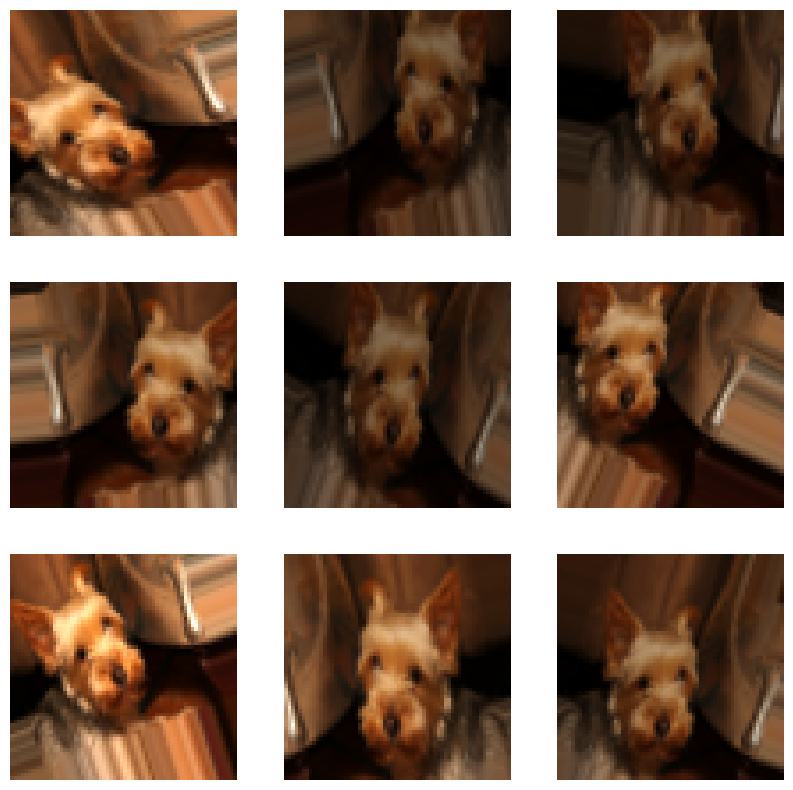

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = next(datagen.flow(images, shuffle=False))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].astype("uint8"))
        plt.axis("off")

plt.show()


In [46]:
from keras.callbacks import ModelCheckpoint
augumented_callbacks = ModelCheckpoint(filepath='best_model_augumented.keras', monitor='val_accuracy', save_best_only=True)
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.5),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(1024, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(1024, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.8),
    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 52,381,861 (199.82 MB)

 Trainable params: 52,374,181 (199.79 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [49]:
epochs=150
history = model.fit(
    datagen.flow(train_images, train_labels, shuffle=True),
    validation_data=datagen.flow(val_images, val_labels, shuffle=True),
    epochs=epochs,
    callbacks=[augumented_callbacks, tf.keras.callbacks.LearningRateScheduler(scheduler)]
)

Epoch 1/150


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.0316 - loss: 7.5694 - val_accuracy: 0.0307 - val_loss: 5.0205 - learning_rate: 1.0000e-04
Epoch 2/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.0430 - loss: 4.3023 - val_accuracy: 0.0379 - val_loss: 4.1451 - learning_rate: 1.0000e-04
Epoch 3/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.0538 - loss: 3.6806 - val_accuracy: 0.0424 - val_loss: 3.7860 - learning_rate: 1.0000e-04
Epoch 4/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.0648 - loss: 3.5791 - val_accuracy: 0.0631 - val_loss: 3.6044 - learning_rate: 1.0000e-04
Epoch 5/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.0752 - loss: 3.4882 - val_accuracy: 0.0460 - val_loss: 3.5976 - learning_rate: 1.0000e-04
Epoch 6/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.0780 - loss: 3.4511 - val_accuracy: 0.0676 - val_loss: 3.5907 - learning_rate: 1.0000e-04
Epoch 7/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy

ValueError: The output of the `schedule` function should be a float. Got: 9.048374340636656e-05

In [50]:
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


In [51]:
from keras.models import load_model

model = load_model('best_model_augumented.keras')

epochs = 150
history = model.fit(
    datagen.flow(train_images, train_labels, shuffle=True),
    validation_data=datagen.flow(val_images, val_labels, shuffle=True),
    initial_epoch=100, 
    epochs=epochs,
    callbacks=[augumented_callbacks, tf.keras.callbacks.LearningRateScheduler(scheduler)]
)


Epoch 101/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.8270 - loss: 0.5195 - val_accuracy: 0.5419 - val_loss: 1.8656 - learning_rate: 9.0484e-05
Epoch 102/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8399 - loss: 0.4861 - val_accuracy: 0.5924 - val_loss: 1.6590 - learning_rate: 8.1873e-05
Epoch 103/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8359 - loss: 0.4946 - val_accuracy: 0.5690 - val_loss: 1.7829 - learning_rate: 7.4082e-05
Epoch 104/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8612 - loss: 0.4151 - val_accuracy: 0.5951 - val_loss: 1.6836 - learning_rate: 6.7032e-05
Epoch 105/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8542 - loss: 0.4313 - val_accuracy: 0.6078 - val_loss: 1.7191 - learning_rate: 6.0653e-05
Epoch 106/150
162/162 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.8696 - loss: 0.3886 - val_accuracy: 0.6005 - val_loss: 1.6472 - learning_rate: 5.4881e-05
Epoch 107/150
162/162 ━━━━━━━━━━━━━━━━━━

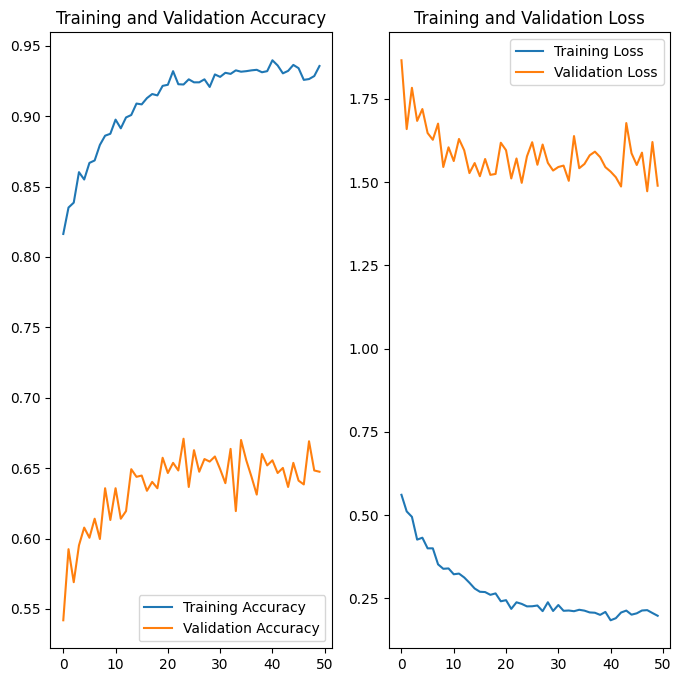

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [54]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step


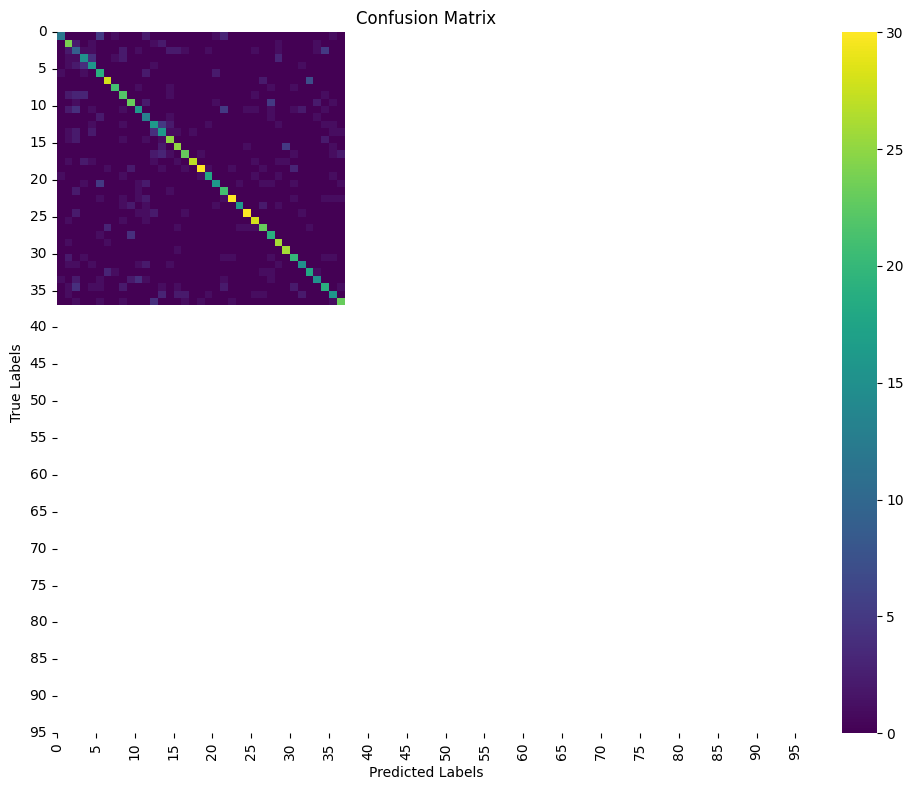

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predicted_val_labels = model.predict(val_images)
predicted_val_labels = np.argmax(predicted_val_labels, axis=1)

cm = confusion_matrix(val_labels, predicted_val_labels)

class_labels = range(0, 96, 5)

plt.figure(figsize=(10, 8))

if cm.max() > 0:
    sns.heatmap(cm, annot=False, fmt="d", cmap='viridis')
else:
    plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=class_labels, labels=class_labels)
plt.yticks(ticks=class_labels, labels=class_labels)

plt.tight_layout()
plt.show()

In [59]:
for i in range(len(test_images)):
    image = test_images[i]
    label = test_labels[i]
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    print(f"True label: {class_names[label]}, Predicted label: {class_names[predicted_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
True label: 36, Predicted label: 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
True label: 18, Predicted label: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
True label: 7, Predicted label: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
True label: 30, Predicted label: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
True label: 20, Predicted label: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
True label: 18, Predicted label: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
True label: 29, Predicted label: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
True label: 19, Predicted label: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
True label: 25, Predicted label: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
True label: 10, Predicted label: 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
True label: 10, Predicted label: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
True label: 23, Predicted label: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
True label: 23, Predicted label: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr

In [60]:
model.evaluate(test_images, test_labels)

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 443ms/step - accuracy: 0.6838 - loss: 1.4597


[1.4813990592956543, 0.6798917651176453]

In [61]:
first_model = load_model('best_model.keras')

In [62]:
first_model.evaluate(test_images, test_labels)

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step - accuracy: 0.4076 - loss: 3.2581


[3.3224079608917236, 0.3913435637950897]